In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import cv2
import imageio

import matplotlib.pyplot as plt

# Topological features of vessel segmentation maps

We import our prepared dataset class, and load the DRIVE training dataset using OpenCV and `imageio`.

In [3]:
from utils.loaders import DATASET_MAP

In [4]:
dataset = DATASET_MAP['DRIVE']['train']

In [5]:
import skimage

_idx = 1
img = cv2.cvtColor(cv2.imread(dataset.images[_idx]), cv2.COLOR_BGR2RGB)
target = np.asarray(imageio.imread(dataset.targets[_idx]))  # this is a gif, load with imageio

target = target.astype(float) / 255

# preprocess the target with gaussian blur for smoothing
target_smoothed = skimage.filters.gaussian(target, 1)

In [6]:
gs_thresh_ = 0.1
target_grown = (target_smoothed > gs_thresh_).astype(float)

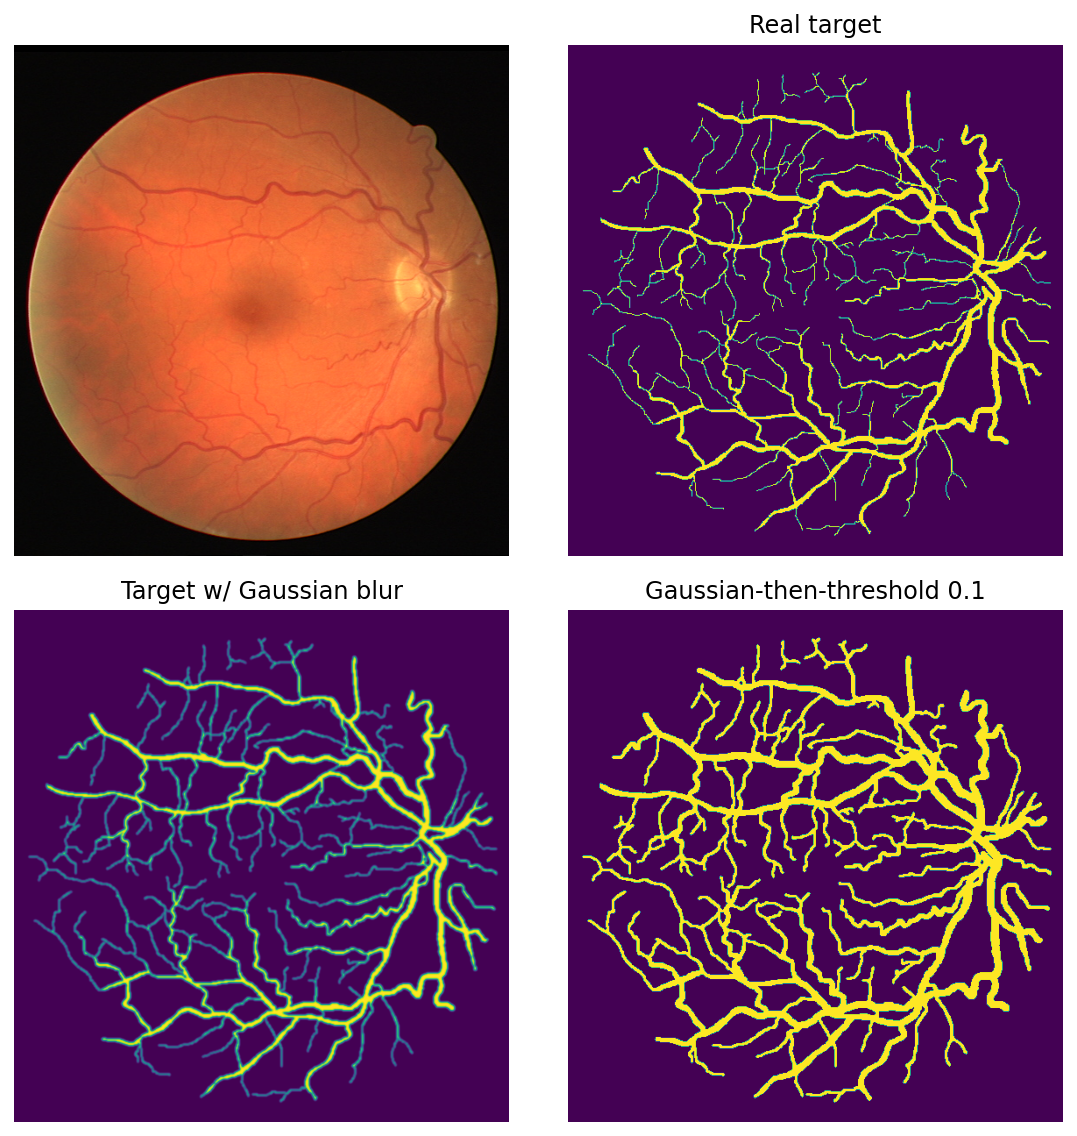

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
axes[0].imshow(img)
axes[0].axis('off')

axes[1].imshow(target)
axes[1].axis('off');
axes[1].set_title("Real target")

axes[2].imshow(target_smoothed)
axes[2].axis('off');
axes[2].set_title("Target w/ Gaussian blur")

axes[3].imshow(target_grown)
axes[3].axis('off');
axes[3].set_title("Gaussian-then-threshold {:.1f}".format(gs_thresh_))
fig.tight_layout()

## Persistent homology

Now, we want to extract topological features from the target map using persistent homology. We will use the `gudhi` library for its performance.

Following the approach of [this paper](https://arxiv.org/pdf/1901.10244.pdf) and [repo](https://github.com/JamesClough/topograd), we use a cubical complex built over the pixels and the appropriate Bernoulli-like filtration.

In [8]:
import gudhi as gd
from gudhi import CubicalComplex

### Persistence of the real segmentation map

In [76]:
cub_splx = CubicalComplex(list(target.shape),
                          top_dimensional_cells=1-target.flatten())
print("Cubical complex has %d simplices." % cub_splx.num_simplices())

Cubical complex has 1322139 simplices.


In [77]:
persistence_ = cub_splx.persistence(min_persistence=0.1)

print(len(persistence_))

from collections import defaultdict
persistence_dict = defaultdict(list)
for dim, triplet in persistence_:
    persistence_dict[dim].append(triplet)
for dim in persistence_dict:
    persistence_dict[dim] = np.asarray(persistence_dict[dim])

for dim, arr in persistence_dict.items():
    print("Dimension {:d}: persistence values\n".format(dim), np.unique(arr,axis=0))

4724
Dimension 1: persistence values
 [[0. 1.]]
Dimension 0: persistence values
 [[ 0.  1.]
 [ 0. inf]]


We now plot the image along with its persistence barcodes:

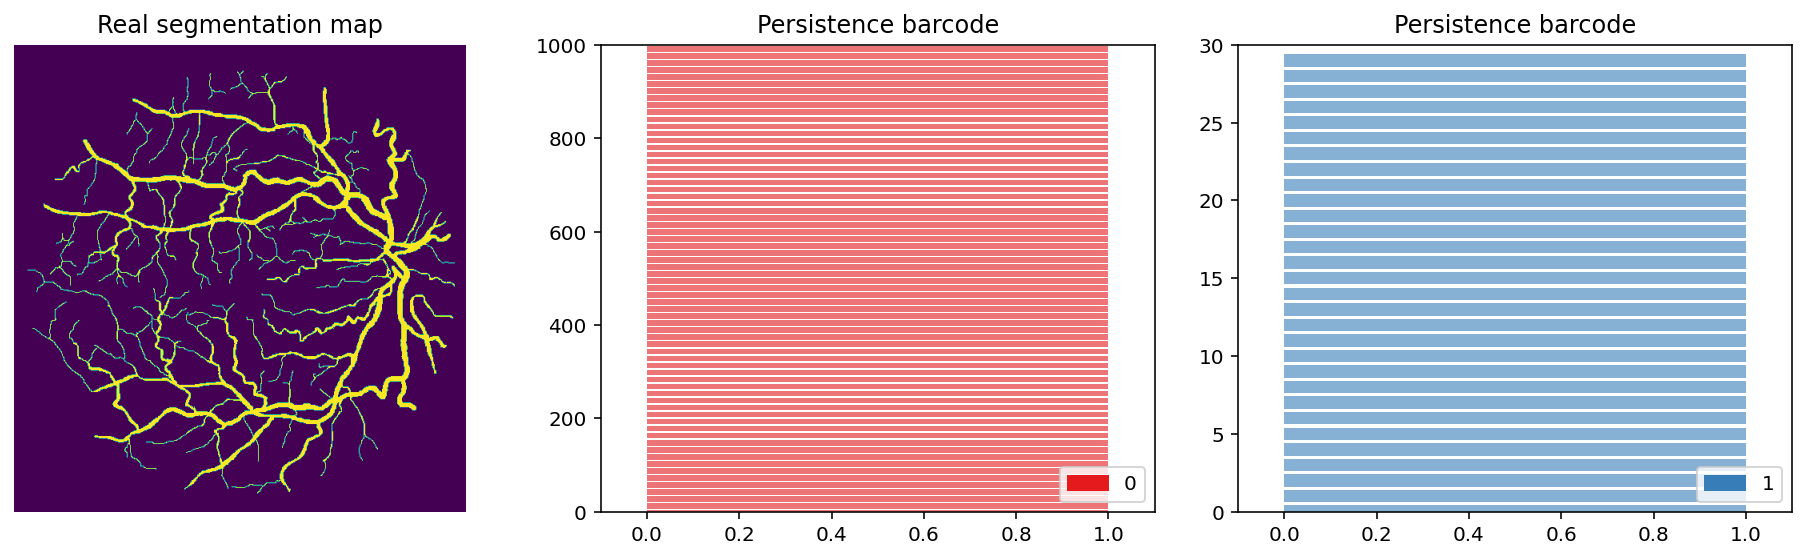

In [78]:
fig = plt.figure(figsize=(13, 4))
ax = fig.add_subplot(131)
ax.imshow(target)
ax.axis('off')
ax.set_title("Real segmentation map")

ax = fig.add_subplot(132)
gd.plot_persistence_barcode([t for t in persistence_ if t[0]==0], alpha=.6,
                            legend=True, axes=ax)
ax = fig.add_subplot(133)
gd.plot_persistence_barcode([t for t in persistence_ if t[0]==1], alpha=.6,
                            legend=True, axes=ax)
fig.tight_layout()

In [85]:
cub_splx.persistent_betti_numbers(0., .5)

[4694, 30, 0]

In [72]:
import os

In [75]:
file_base_name_ = os.path.splitext(os.path.basename(dataset.images[_idx]))[0]

In [80]:
fig.savefig("figures/persistence-barcodes-{:s}-.pdf".format(file_base_name_),
            bbox_inches=None)